# **Capstone Project : Predicting Air Quality Index Category in Delhi Using Machine Learning**

### **Background and Introdution**

Delhi, India’s capital and a densely populated urban hub, has experienced severe air quality deterioration in recent decades. The causes of air pollution in Delhi are multifaceted, including industrial emissions, vehicular pollution, crop residue burning in neighboring states, construction dust, its peculiar geographical location and meteorological effects. Numerous steps have been taken by the local government to tackle this issue, however, with limited success. Machine learning based predictive models are vital for forecasting air quality index to help the government and the local population take necessary actions to minimize adverse effects of pollution.

### **Research Question**

Can we develop a robust machine learning model that accurately predicts the Air Quality Index (AQI) category — Good, Satisfactory,  Moderate, Poor, Very Poor, Severe — for Delhi using daily pollutant concentration levels and weather data?


### **Data**

This project required 2 types of data - air quality data(pollutant levels) and meteorological data (temperature, humidity, wind speed, etc.) for the Indian capital city of Delhi. The data has been sourced from following sources :-

- Air Quality Data - obtained from https://www.kaggle.com/code/yashvi/air-quality-analysis-of-delhi/data
    
- Weather Data - obtained from the https://www.visualcrossing.com/weather-query-builder/

In [5]:
#importing required packages / libraries
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

**Loading Pollution Dataset**

In [8]:
DATA_DIR = Path("data")

# Load pollution dataset
df_pollution = pd.read_csv(DATA_DIR / "delhi_pollution.csv")

In [10]:
df_pollution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707875 entries, 0 to 707874
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   City        707875 non-null  object 
 1   Datetime    707875 non-null  object 
 2   PM2.5       562787 non-null  float64
 3   PM10        411138 non-null  float64
 4   NO          591243 non-null  float64
 5   NO2         590753 non-null  float64
 6   NOx         584651 non-null  float64
 7   NH3         435333 non-null  float64
 8   CO          621358 non-null  float64
 9   SO2         577502 non-null  float64
 10  O3          578667 non-null  float64
 11  Benzene     544229 non-null  float64
 12  Toluene     487268 non-null  float64
 13  Xylene      252046 non-null  float64
 14  AQI         578795 non-null  float64
 15  AQI_Bucket  578795 non-null  object 
dtypes: float64(13), object(3)
memory usage: 86.4+ MB


In [12]:
#checking the list of cities covered by the dataset
df_pollution['City'].value_counts()

City
Ahmedabad             48192
Delhi                 48192
Mumbai                48192
Bengaluru             48192
Lucknow               48192
Chennai               48192
Hyderabad             48107
Patna                 44554
Gurugram              40258
Visakhapatnam         35053
Amritsar              29269
Jorapokhar            28025
Jaipur                26705
Thiruvananthapuram    26651
Amaravati             22784
Brajrajnagar          22468
Talcher               22161
Kolkata               19503
Guwahati              12002
Coimbatore             9229
Shillong               7402
Chandigarh             7263
Bhopal                 6903
Kochi                  3854
Ernakulam              3852
Aizawl                 2680
Name: count, dtype: int64

For the purpose of this project, I intend to limit my work to data pertaining to Delhi.
Therefore, limiting the dataset to entries pertaining to Delhi only. 

In [15]:
#limiting the dataset to entries pertaining to Delhi only
delhi_pollution = df_pollution[df_pollution['City'] == 'Delhi']

In [17]:
#checking for list of cities again
delhi_pollution['City'].value_counts()

City
Delhi    48192
Name: count, dtype: int64

In [19]:
#converting 'Datetime' column to pandas datetime objects
delhi_pollution.loc[:, 'Datetime'] = pd.to_datetime(delhi_pollution['Datetime'], errors='coerce')

In [21]:
print(delhi_pollution['Datetime'].dtype)

object


In [23]:
#changing column name from 'Datetime' to 'datetime'
delhi_pollution = delhi_pollution.rename(columns={'Datetime': 'datetime'})

In [25]:
delhi_pollution['datetime'] = pd.to_datetime(delhi_pollution['datetime'])

In [27]:
print(delhi_pollution['datetime'].dtype)

datetime64[ns]


In [29]:
#getting the first and last datetime entries
start_time_pollution = delhi_pollution['datetime'].min()
end_time_pollution = delhi_pollution['datetime'].max()

print("First entry:", start_time_pollution)
print("Last entry:", end_time_pollution)

First entry: 2015-01-01 01:00:00
Last entry: 2020-07-01 00:00:00


In [31]:
#creating a variable for datetime range of the dataset
full_range_pollution = pd.date_range(start=start_time_pollution, end=end_time_pollution, freq='h')

In [33]:
print(delhi_pollution.columns)

Index(['City', 'datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
       'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


In [35]:
#defining function for checking missing values - The following function returns a summary table showing the count and percentage of missing values in each column.

def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns explicitly
    mis_val_table.columns = ['Missing Values', '% of Total Values']
    
    # Filter out columns with no missing data and sort descending
    mis_val_table = mis_val_table[mis_val_table['Missing Values'] != 0]
    mis_val_table = mis_val_table.sort_values('% of Total Values', ascending=False).round(1)
    
    # Print summary
    print(f"Selected dataframe has {df.shape[1]} columns.")
    print(f"There are {mis_val_table.shape[0]} columns that have missing values.")
    
    return mis_val_table

In [37]:
print(delhi_pollution.dtypes)

City                  object
datetime      datetime64[ns]
PM2.5                float64
PM10                 float64
NO                   float64
NO2                  float64
NOx                  float64
NH3                  float64
CO                   float64
SO2                  float64
O3                   float64
Benzene              float64
Toluene              float64
Xylene               float64
AQI                  float64
AQI_Bucket            object
dtype: object


In [39]:
#selecting only object (categorical) columns
categorical_cols = delhi_pollution.select_dtypes(include='object').columns

#loop through each and print unique values
for col in categorical_cols:
    unique_vals = delhi_pollution[col].unique()
    print(f"\nColumn: {col}")
    print(f"Unique values ({len(unique_vals)}): {unique_vals}")


Column: City
Unique values (1): ['Delhi']

Column: AQI_Bucket
Unique values (7): [nan 'Severe' 'Very Poor' 'Poor' 'Moderate' 'Satisfactory' 'Good']


In [41]:
delhi_pollution['AQI_Bucket'].isna().sum()

498

In [43]:
#checking missing timestamps by comparing with actual datetime column
missing_hours = full_range_pollution.difference(delhi_pollution['datetime'])

# View how many and which ones
print(f"Missing hourly entries: {len(missing_hours)}")
print(missing_hours)

Missing hourly entries: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='h')


**Loading dataset for Weather data**

The weather dataset for Delhi includes hourly records of temperature, humidity, wind speed and other meteorological variables. We'll align its date range with the pollution dataset for consistent analysis.

In [47]:
df_weather = pd.read_csv(DATA_DIR / "delhi_weather.csv")

df_weather.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"Delhi, DL, India",2015-01-01T00:00:00,10.0,10.0,10.0,100.00,0.0,0,NaN,0.0,...,1017.0,25.0,1.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,VIDP
1,"Delhi, DL, India",2015-01-01T01:00:00,9.0,9.0,9.0,100.00,0.0,0,NaN,0.0,...,1017.0,25.0,0.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,VIDP
2,"Delhi, DL, India",2015-01-01T02:00:00,9.1,9.1,8.5,96.22,0.0,0,NaN,0.0,...,1016.8,43.5,0.7,0.0,0.0,0.0,NaN,Partially cloudy,fog,"42182099999,VIDP,42181099999"
3,"Delhi, DL, India",2015-01-01T03:00:00,9.6,9.6,9.6,100.00,0.0,0,NaN,0.0,...,1016.0,27.2,0.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"VIDP,42181099999"
4,"Delhi, DL, India",2015-01-01T04:00:00,10.0,10.0,10.0,100.00,0.0,0,NaN,0.0,...,1017.0,88.0,0.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,VIDP


In [49]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92040 entries, 0 to 92039
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              92040 non-null  object 
 1   datetime          92040 non-null  object 
 2   temp              92040 non-null  float64
 3   feelslike         92040 non-null  float64
 4   dew               92040 non-null  float64
 5   humidity          92040 non-null  float64
 6   precip            92039 non-null  float64
 7   precipprob        92040 non-null  int64  
 8   preciptype        2470 non-null   object 
 9   snow              92030 non-null  float64
 10  snowdepth         92030 non-null  float64
 11  windgust          92022 non-null  float64
 12  windspeed         92040 non-null  float64
 13  winddir           92039 non-null  float64
 14  sealevelpressure  92040 non-null  float64
 15  cloudcover        92035 non-null  float64
 16  visibility        90813 non-null  float6

In [51]:
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'], errors='coerce')

In [53]:
#getting the first and last datetime entries
first_date = df_weather['datetime'].min()
last_date = df_weather['datetime'].max()

print("First entry:", first_date)
print("Last entry:", last_date)

First entry: 2015-01-01 00:00:00
Last entry: 2025-07-01 23:00:00


In [55]:
#filtering the dataset to desired datetime range to match with pollution data
delhi_weather = df_weather[
    (df_weather['datetime'] >= start_time_pollution) &
    (df_weather['datetime'] <= end_time_pollution)
].copy()

In [57]:
print(delhi_weather['datetime'].dtype)

datetime64[ns]


In [59]:
#getting the first and last datetime entries
start_time_weather = delhi_weather['datetime'].min()
end_time_weather = delhi_weather['datetime'].max()

print("First entry:", start_time_weather)
print("Last entry:", end_time_weather)

First entry: 2015-01-01 01:00:00
Last entry: 2020-07-01 00:00:00


In [61]:
#creating a variable for datetime range of the dataset
full_range_weather = pd.date_range(start=start_time_weather, end=end_time_weather, freq='h')

In [63]:
missing_delhi_weather = missing_values_table(delhi_weather)
display(missing_delhi_weather)

Selected dataframe has 24 columns.
There are 12 columns that have missing values.


,Missing Values,% of Total Values
severerisk,48192,100.0
preciptype,47377,98.3
visibility,1029,2.1
solarradiation,18,0.0
solarenergy,18,0.0
uvindex,18,0.0
windgust,17,0.0
snow,10,0.0
snowdepth,10,0.0
cloudcover,5,0.0


In [65]:
#selecting only object (categorical) columns
categorical_cols = delhi_weather.select_dtypes(include='object').columns

#loop through each and print unique values
for col in categorical_cols:
    unique_vals = delhi_weather[col].unique()
    print(f"\nColumn: {col}")
    print(f"Unique values ({len(unique_vals)}): {unique_vals}")


Column: name
Unique values (1): ['Delhi, DL, India']

Column: preciptype
Unique values (2): [nan 'rain']

Column: conditions
Unique values (6): ['Partially cloudy' 'Clear' 'Overcast' 'Rain, Overcast'
 'Rain, Partially cloudy' 'Rain']

Column: icon
Unique values (8): ['partly-cloudy-night' 'fog' 'clear-day' 'partly-cloudy-day' 'cloudy'
 'clear-night' 'rain' 'wind']

Column: stations
Unique values (37): ['VIDP' '42182099999,VIDP,42181099999' 'VIDP,42181099999' 'remote'
 '42182099999,VIDP' '42182099999' '42182099999,42181099999' '42181099999'
 '42182099999,VIDP,42139099999,42181099999' '42182099999,VIDP,42139099999'
 '42182099999,42139099999,42181099999' '42182099999,VIDP,42181099999,VIDD'
 '42182099999,VIDP,42139099999,42181099999,VIDD' 'VIDP,42181099999,VIDD'
 '42182099999,VIDD' 'VIDP,42139099999,42181099999' 'VIDP,VIDD'
 '42182099999,42181099999,VIDD' '42182099999,42139099999,VIDD'
 '42182099999,VIDP,VIDD' '42139099999,42181099999'
 '42182099999,42139099999,42181099999,VIDD'
 '4218209

In [67]:
delhi_weather = delhi_weather.copy()

**Dropping redundant or unnecessary columns**

The following columns are dropped as they are redundant, irrelevant or have minimal analytical value for air pollution modeling:-

- `name`: All records pertain to Delhi.
- `feelslike`: Duplicates the `temp` column.
- `precipprob`, `preciptype`, `snow`, `snowdepth`: Redundant with `precip`.
- `visibility`, `severerisk`: Low analytical relevance for AQI prediction.
- `icon`: Non-numeric, aesthetic metadata.
- `stations`: Assumed to be a single consistent source.

In [70]:
#dropping redundant or unnecessary columns
delhi_weather.drop(columns=['name', 'feelslike', 'precipprob', 'preciptype', 'snow', 'snowdepth', 
                            'visibility', 'severerisk', 'icon', 'stations'], inplace=True)

In [72]:
delhi_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48192 entries, 1 to 48192
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          48192 non-null  datetime64[ns]
 1   temp              48192 non-null  float64       
 2   dew               48192 non-null  float64       
 3   humidity          48192 non-null  float64       
 4   precip            48191 non-null  float64       
 5   windgust          48175 non-null  float64       
 6   windspeed         48192 non-null  float64       
 7   winddir           48191 non-null  float64       
 8   sealevelpressure  48192 non-null  float64       
 9   cloudcover        48187 non-null  float64       
 10  solarradiation    48174 non-null  float64       
 11  solarenergy       48174 non-null  float64       
 12  uvindex           48174 non-null  float64       
 13  conditions        48192 non-null  object        
dtypes: datetime64[ns](1), float

In [74]:
#checking missing timestamps by comparing with actual datetime column
missing_hours = full_range_weather.difference(delhi_weather['datetime'])

print(f"Missing hourly entries: {len(missing_hours)}")
print(missing_hours)

Missing hourly entries: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='h')


In [76]:
print(f"Number of rows in delhi_pollution dataset: {delhi_pollution.shape[0]}")
print(f"Number of rows in delhi_weather dataset: {delhi_weather.shape[0]}")

Number of rows in delhi_pollution dataset: 48192
Number of rows in delhi_weather dataset: 48192


**Merging Pollution and Weather datasets**

In [79]:
#merging the datasets for pollution and weather together for further handling
delhi_polln_wthr = pd.merge(delhi_pollution, delhi_weather, on='datetime')

Both datasets (delhi_pollution and delhi_weather) have been merged on the common `datetime` column. This enables time-based alignment of pollution levels with corresponding weather features, essential for modeling and analysis.

In [82]:
delhi_polln_wthr.head()

,City,datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,precip,windgust,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,conditions
0,Delhi,2015-01-01 01:00:00,454.58,935.18,81.52,41.78,187.66,27.54,9.29,3.41,...,0.0,11.5,0.0,0.0,1017.0,25.0,0.0,0.0,0.0,Partially cloudy
1,Delhi,2015-01-01 02:00:00,440.44,NaN,70.80,43.46,176.83,27.72,13.28,3.88,...,0.0,15.1,0.0,0.0,1016.8,43.5,0.0,0.0,0.0,Partially cloudy
2,Delhi,2015-01-01 03:00:00,409.09,NaN,132.46,41.19,141.02,28.94,29.67,2.83,...,0.0,15.5,0.0,0.0,1016.0,27.2,0.0,0.0,0.0,Partially cloudy
3,Delhi,2015-01-01 04:00:00,436.12,NaN,84.78,39.55,102.84,29.30,21.76,4.33,...,0.0,14.0,0.0,0.0,1017.0,88.0,0.0,0.0,0.0,Partially cloudy
4,Delhi,2015-01-01 05:00:00,415.88,976.99,60.24,37.41,80.12,30.84,26.19,6.17,...,0.0,12.2,0.0,0.0,1016.1,89.7,0.0,0.0,0.0,Partially cloudy


In [84]:
delhi_polln_wthr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48192 entries, 0 to 48191
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   City              48192 non-null  object        
 1   datetime          48192 non-null  datetime64[ns]
 2   PM2.5             47817 non-null  float64       
 3   PM10              45771 non-null  float64       
 4   NO                47894 non-null  float64       
 5   NO2               47862 non-null  float64       
 6   NOx               48167 non-null  float64       
 7   NH3               47212 non-null  float64       
 8   CO                47828 non-null  float64       
 9   SO2               45340 non-null  float64       
 10  O3                45991 non-null  float64       
 11  Benzene           48154 non-null  float64       
 12  Toluene           48166 non-null  float64       
 13  Xylene            29288 non-null  float64       
 14  AQI               4769

In [86]:
#checking for missing values
missing_delhi_polln_wthr = missing_values_table(delhi_polln_wthr)
display(missing_delhi_polln_wthr)

Selected dataframe has 29 columns.
There are 21 columns that have missing values.


,Missing Values,% of Total Values
Xylene,18904,39.2
SO2,2852,5.9
PM10,2421,5.0
O3,2201,4.6
NH3,980,2.0
AQI,498,1.0
AQI_Bucket,498,1.0
PM2.5,375,0.8
CO,364,0.8
NO2,330,0.7


**Linear interpolation** has been used to fill missing values in numerical columns. This method assumes gradual temporal variation, making it well-suited for environmental time-series data like weather and pollution.

In [89]:
#setting datetime as index
delhi_polln_wthr.set_index('datetime', inplace=True)

#seperating out numerical columns for linear interpolation 
numeric_cols = delhi_polln_wthr.select_dtypes(include='number').columns

#carrying out linear interpolation
df_interpolated = delhi_polln_wthr.copy()
df_interpolated[numeric_cols] = df_interpolated[numeric_cols].interpolate(method='time')

In [91]:
#checking for missing values
missing_values_table(df_interpolated)

Selected dataframe has 28 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
AQI_Bucket,498,1.0
AQI,15,0.0


Since, the number of missing values is very small (15), these can be safely dropped without affecting the data.

In [94]:
#dropping rows where AQI is still missing
df_interpolated_clean = df_interpolated.dropna(subset=['AQI'])

In [96]:
df_interpolated_clean.shape

(48177, 28)

In [98]:
#checking for missing values
missing_values_table(df_interpolated_clean)

Selected dataframe has 28 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
AQI_Bucket,483,1.0


AQI Bucket is defined by the actual AQI value. Hence, it will be prudent to drop 'AQI_Bucket' and replace it with 'AQI_Bucket_Calculated' to ensure data consistency. For calculation, we will use the parameters as laid down by CPCB to define a function to calculate AQI Bucket based on the AQI value. Laid down categorization can be accessed here https://airquality.cpcb.gov.in/AQI_India/ 

In [101]:
#defining AQI categorization function
def categorize_aqi(AQI):
    if AQI <= 50:
        return "Good"
    elif AQI <= 100:
        return "Satisfactory"
    elif AQI <= 200:
        return "Moderate"
    elif AQI <= 300:
        return "Poor"
    elif AQI <= 400:
        return "Very Poor"
    else:
        return "Severe"

In [103]:
#creating a copy
df_interpolated_clean = df_interpolated_clean.copy()

#applying categorization to create new column
df_interpolated_clean['AQI_Bucket_Calculated'] = df_interpolated_clean['AQI'].apply(categorize_aqi)

In [105]:
df_interpolated_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48177 entries, 2015-01-01 16:00:00 to 2020-07-01 00:00:00
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   48177 non-null  object 
 1   PM2.5                  48177 non-null  float64
 2   PM10                   48177 non-null  float64
 3   NO                     48177 non-null  float64
 4   NO2                    48177 non-null  float64
 5   NOx                    48177 non-null  float64
 6   NH3                    48177 non-null  float64
 7   CO                     48177 non-null  float64
 8   SO2                    48177 non-null  float64
 9   O3                     48177 non-null  float64
 10  Benzene                48177 non-null  float64
 11  Toluene                48177 non-null  float64
 12  Xylene                 48177 non-null  float64
 13  AQI                    48177 non-null  float64
 14  AQI_Bucket         

To prepare the dataset for modeling, we drop the following:-
- `City`: All rows pertain to Delhi.
- `AQI_Bucket`: Replaced by accurately recalculated `AQI_Bucket_Calculated`.
- `conditions`: Redundant; relevant weather impact is captured through `precip` and `cloudcover`.

In [108]:
#dropping the columns for 'City', 'conditions' and 'AQI_Bucket'
df_interpolated_clean.drop(columns=['City', 'conditions', 'AQI_Bucket'], inplace=True, errors='ignore')

In [110]:
#checking the list of columns
df_interpolated_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48177 entries, 2015-01-01 16:00:00 to 2020-07-01 00:00:00
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PM2.5                  48177 non-null  float64
 1   PM10                   48177 non-null  float64
 2   NO                     48177 non-null  float64
 3   NO2                    48177 non-null  float64
 4   NOx                    48177 non-null  float64
 5   NH3                    48177 non-null  float64
 6   CO                     48177 non-null  float64
 7   SO2                    48177 non-null  float64
 8   O3                     48177 non-null  float64
 9   Benzene                48177 non-null  float64
 10  Toluene                48177 non-null  float64
 11  Xylene                 48177 non-null  float64
 12  AQI                    48177 non-null  float64
 13  temp                   48177 non-null  float64
 14  dew                

In [112]:
#renaming Final Target Column
df_clean = df_interpolated_clean.copy()
df_clean.rename(columns={'AQI_Bucket_Calculated': 'AQI_Bucket'}, inplace=True)

In [114]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48177 entries, 2015-01-01 16:00:00 to 2020-07-01 00:00:00
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PM2.5             48177 non-null  float64
 1   PM10              48177 non-null  float64
 2   NO                48177 non-null  float64
 3   NO2               48177 non-null  float64
 4   NOx               48177 non-null  float64
 5   NH3               48177 non-null  float64
 6   CO                48177 non-null  float64
 7   SO2               48177 non-null  float64
 8   O3                48177 non-null  float64
 9   Benzene           48177 non-null  float64
 10  Toluene           48177 non-null  float64
 11  Xylene            48177 non-null  float64
 12  AQI               48177 non-null  float64
 13  temp              48177 non-null  float64
 14  dew               48177 non-null  float64
 15  humidity          48177 non-null  float64
 16  preci

### **Feature Engineering**
Creating additional columns for hour, month, day of week and year from the 'datetime' column will help in analysis of seasonal patterns

In [118]:
#adding time features 
df_clean['hour'] = df_clean.index.hour
df_clean['month'] = df_clean.index.month
df_clean['dayofweek'] = df_clean.index.dayofweek
df_clean['year'] = df_clean.index.year

Extracted several time-based features from the datetime index to better capture seasonal and daily pollution patterns:-
- `hour` of the day
- `month`
- `dayofweek`
- `year`

In [121]:
#downloading cleaned data for backup
df_clean.to_excel('df_clean_final.xlsx', index=True)

## **Exploratory Data Analysis (EDA)**

We will explore correlations between pollutants, seasonal variations and temporal trends to uncover key relationships and patterns.

Text(0.5, 1.0, 'AQI Category Distribution')

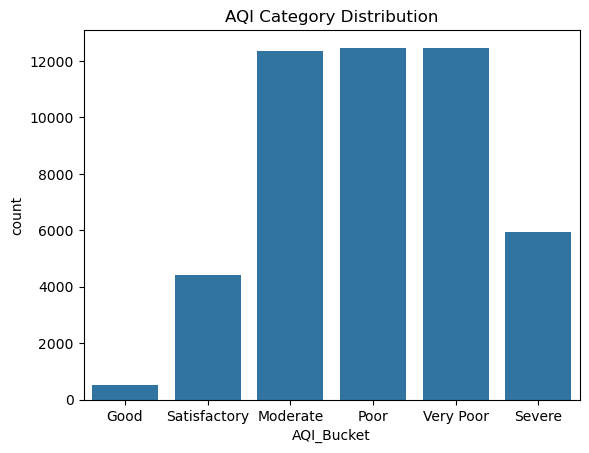

In [124]:
#checking Target Class Distribution
sns.countplot(data=df_clean, x='AQI_Bucket', order=['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe'], )
plt.title("AQI Category Distribution")

**Key Observations**
AQI data is heavily skewed towards Poor to Very Poor categories. This implies the dataset is imbalanced and may require stratified sampling or F1-score-based evaluation during classification.

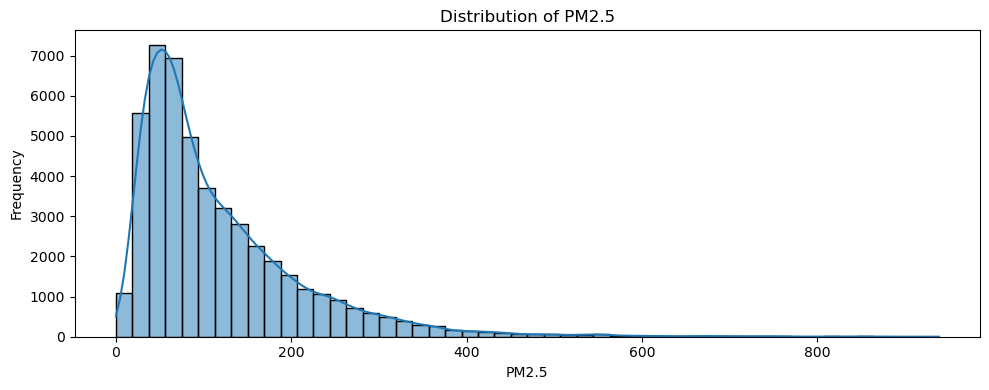

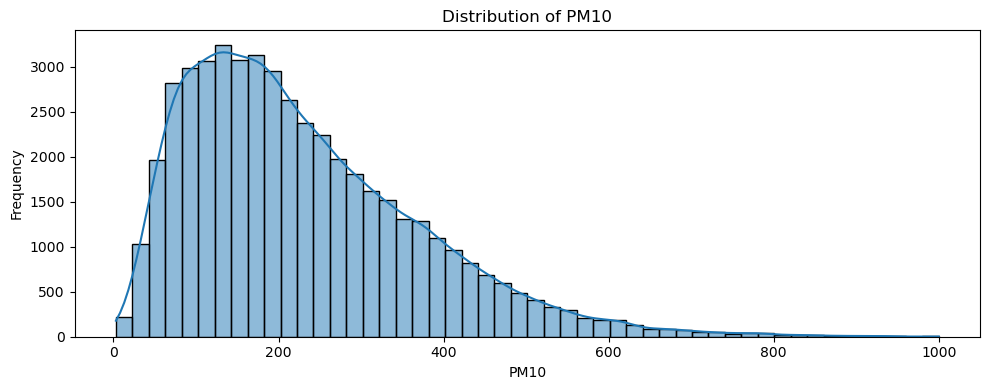

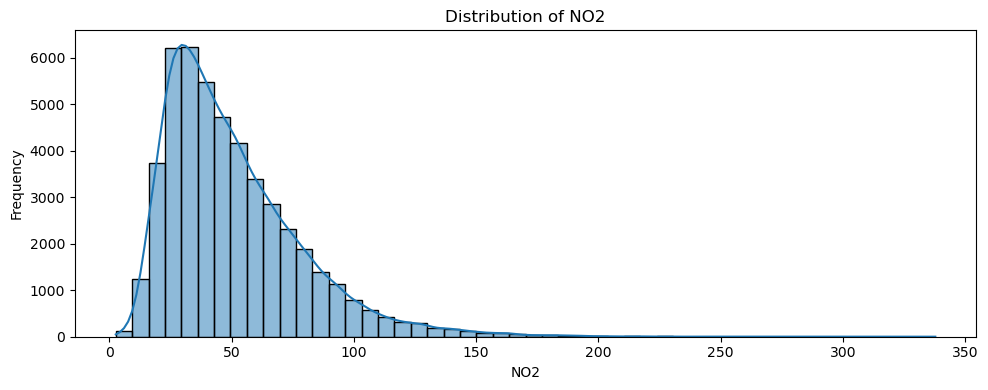

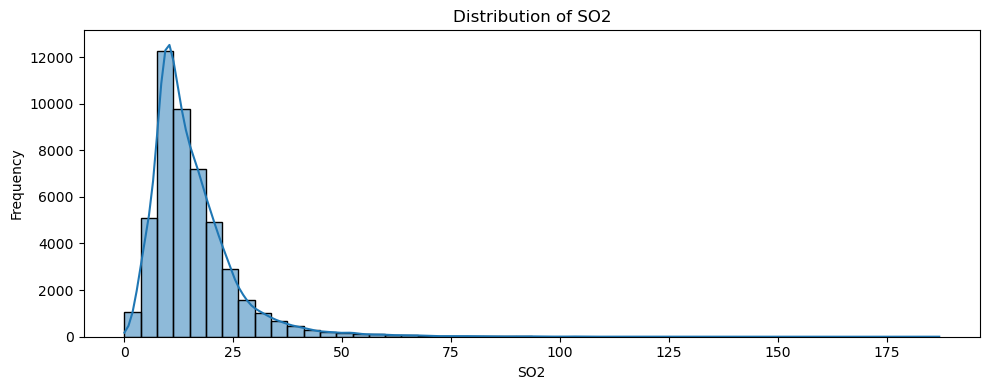

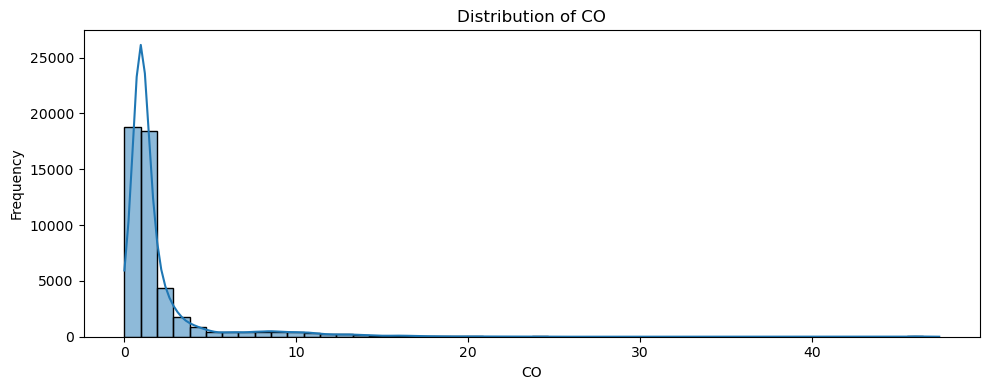

In [126]:
#checking distribution of major pollutants
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO']
for col in pollutants:
    plt.figure(figsize=(10, 4))
    sns.histplot(df_clean[col], kde=True, bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

**Key Observations**
PM2.5 and PM10 are both right-skewed, with a long tail toward high concentrations, typical of urban environments during winter/stubble burning.”
“NO2 and SO2 show similar skewness, indicating possible vehicular or industrial spikes.


Text(0.5, 1.0, 'Correlation Heatmap of Numerical Features')

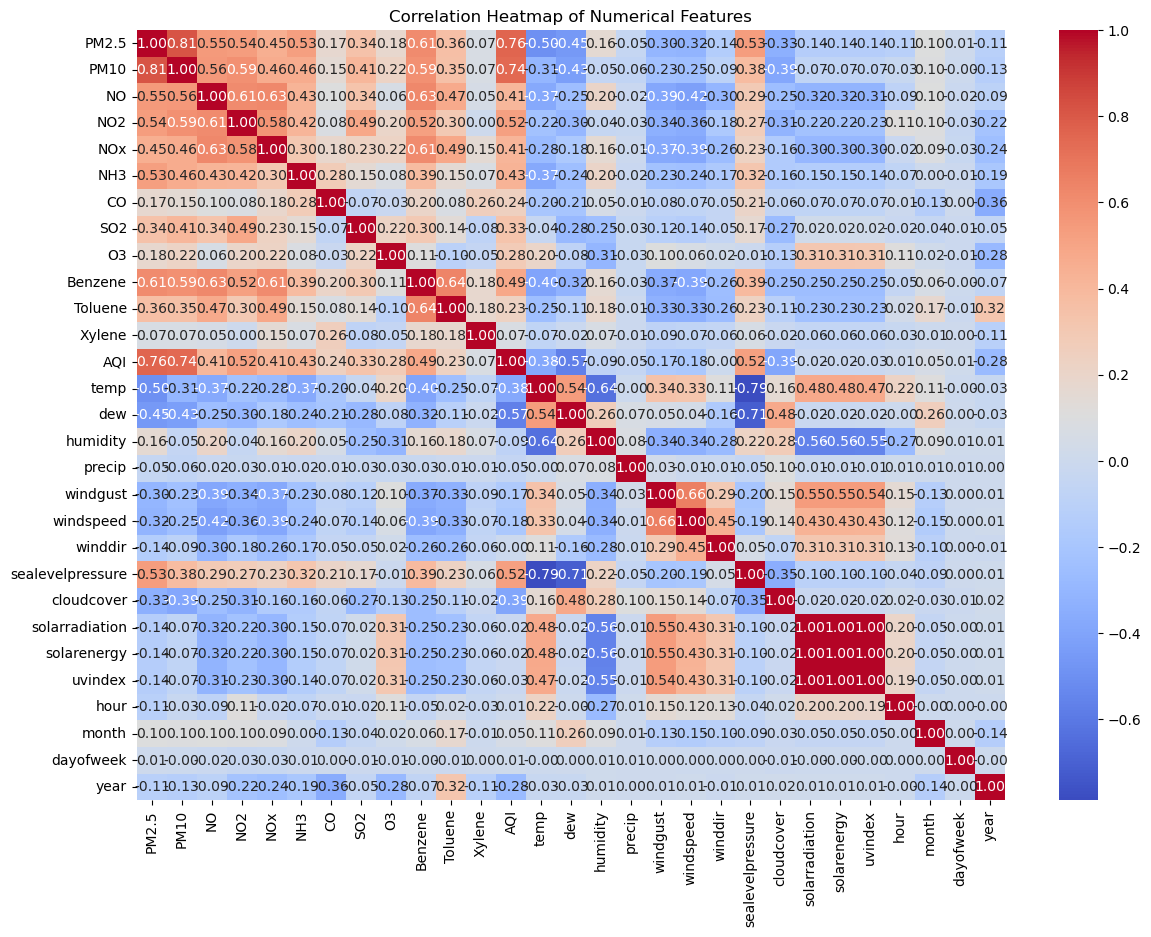

In [128]:
#plotting correlation heatmap
plt.figure(figsize=(14,10))
sns.heatmap(df_clean.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")

**Key Oservations**

The heatmap reveals high correlation between PM2.5 and PM10, as expected. Several gaseous pollutants (NO2, NOx, SO2) also show moderate correlation, potentially useful for prediction.
For better calrity on correlatin, we will plot the correlation matrix as a bar graph.

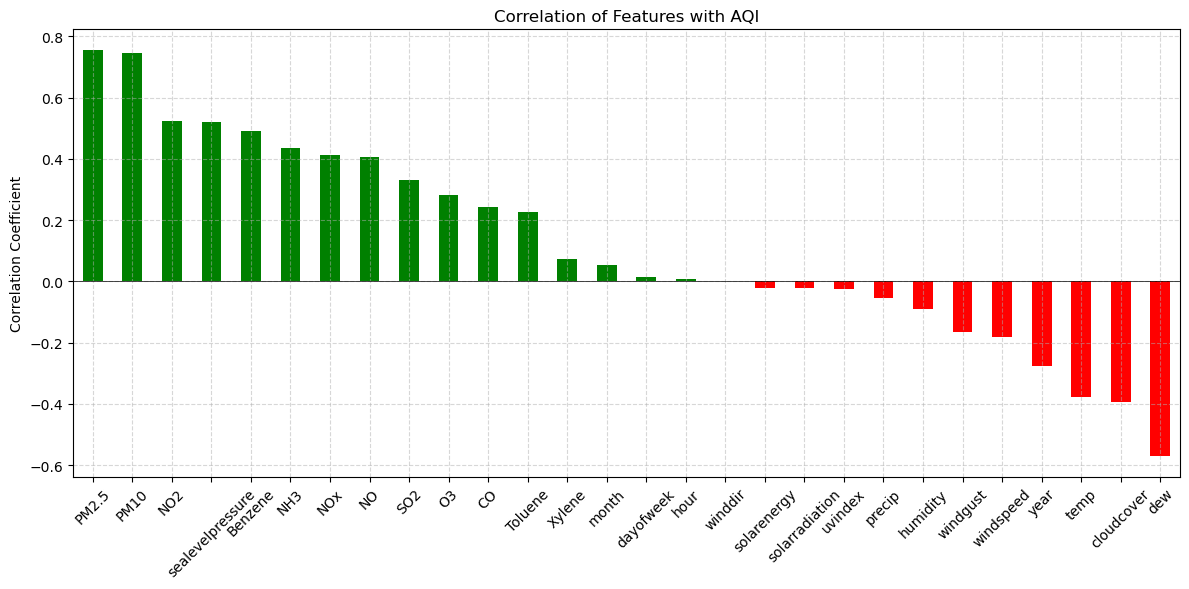

In [130]:
#computing correlation matrix
correlation_matrix = df_clean.corr(numeric_only=True)

#extracting correlation of all features with AQI
aqi_correlations = correlation_matrix['AQI'].sort_values(ascending=False)

#plotting correlation with AQI
plt.figure(figsize=(12, 6))
aqi_correlations.drop('AQI').plot(kind='bar', color=['green' if val > 0 else 'red' for val in aqi_correlations.drop('AQI')])
plt.title("Correlation of Features with AQI")
plt.ylabel("Correlation Coefficient")
plt.axhline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key Observations : Correlation Analysis and Feature Insights**

- Strongest Positive Correlations with AQI:
    - PM2.5 (0.76) and PM10 (0.74): These fine particulate matters are the most dominant predictors of poor air quality in Delhi.
    - NO2 (0.51) and NOx (0.39): Indicative of vehicular and industrial emissions.
    - Sealevel pressure and Benzene also show moderate positive correlation with AQI.

- Moderate Predictors:
    - NH3, NO, SO2, O3, CO: While individually weaker, collectively they contribute to model robustness.
    - Time-based features such as month, hour and dayofweek show minimal correlation but are retained to capture seasonal and temporal variations.

- Strongest Negative Correlations:
    - Dew point (-0.58), Cloudcover (-0.51) and Temperature (-0.43): Cooler, more humid conditions often correlate with higher pollution accumulation.
    - Windspeed and solar radiation also exhibit mild negative correlations, likely due to dispersion effects.

- Implications for Modeling:

    - PM2.5, PM10, NO2 will likely be among the most important features in any tree-based or linear model.
    - Weather variables like temperature, dew and wind help explain AQI variation, especially during pollution spikes in winter.
    - Retaining even weakly correlated time-based features may improve generalization, especially in cross-validation.

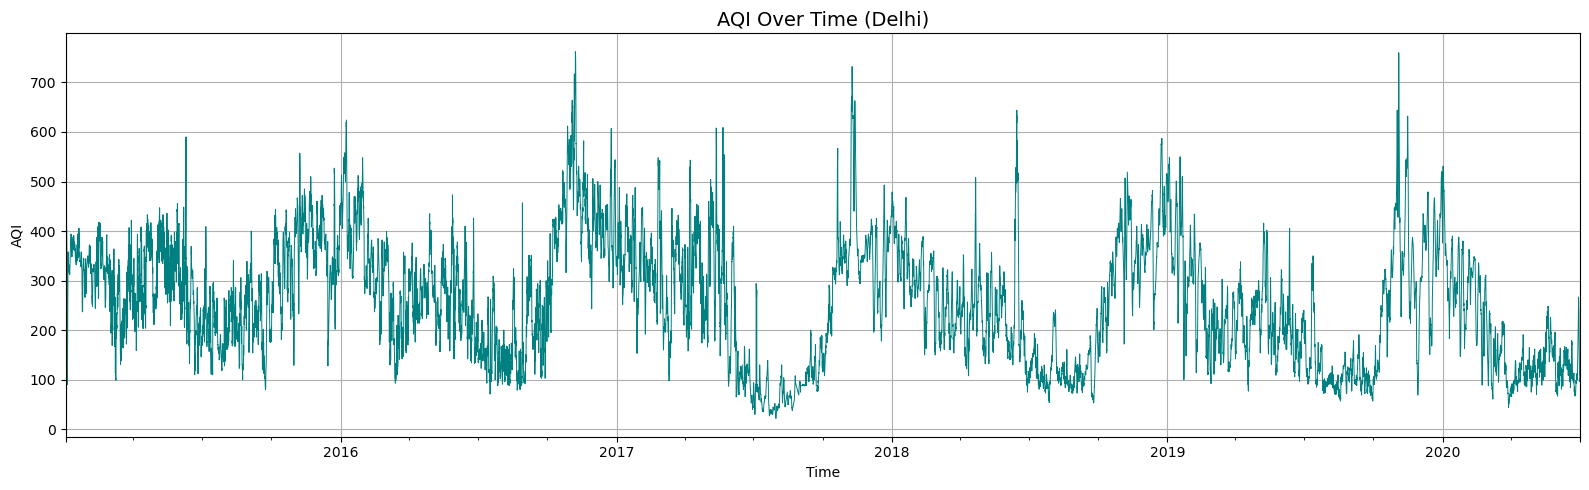

In [132]:
#plotting AQI over time and examining seasonal trends

plt.figure(figsize=(16, 5))
df_clean['AQI'].plot(linewidth=0.7, color='teal')
plt.title('AQI Over Time (Delhi)', fontsize=14)
plt.xlabel('Time')
plt.ylabel('AQI')
plt.grid(True)
plt.tight_layout()
plt.show()

**Key Observations**

- Strong annual seasonality - AQI spikes in post-monsoon and winter months (Oct–Jan) every year.
- Recurring peaks likely due to Diwali festival, crop stubble burning and temperature inversion.
- Sharp dips during monsoon (July–August) each year due to washout effect of rainfall.
- Possible COVID lockdown effects visible around March–June 2020 with unusually low AQI.

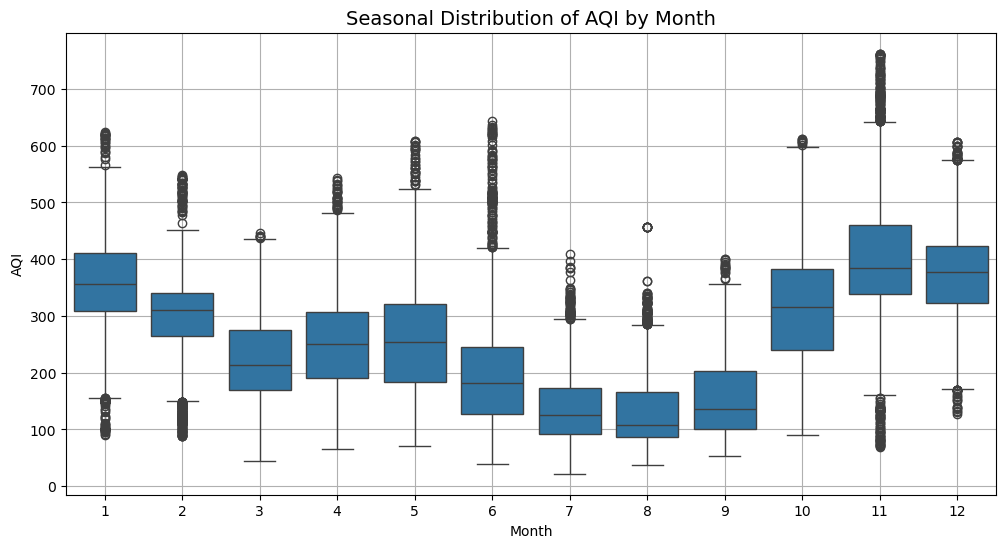

In [134]:
#Monthly Seasonal Trend (Boxplot)

plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='AQI', data=df_clean)
plt.title('Seasonal Distribution of AQI by Month', fontsize=14)
plt.xlabel('Month')
plt.ylabel('AQI')
plt.grid(True)
plt.show()

**Key Observations**

- Peak pollution in winter - November to January exhibit high median AQI and extreme outliers (often > 600).
- Cleaner air in monsoon - July and August show lowest AQI levels, with narrower IQRs and fewer extreme values.
- Transitional rise during October and early spring (Feb–March).

In [136]:
#count of each AQI category
df_clean['AQI_Bucket'].value_counts()

AQI_Bucket
Poor            12466
Very Poor       12462
Moderate        12359
Severe           5952
Satisfactory     4404
Good              534
Name: count, dtype: int64

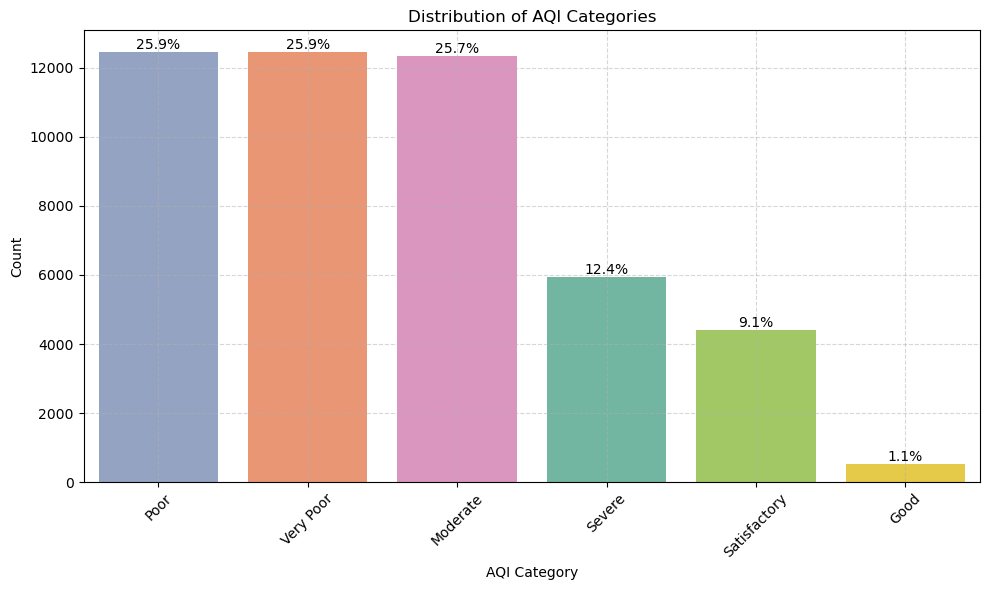

In [137]:
plt.figure(figsize=(10, 6))

# Get value counts and total
aqi_counts = df_clean['AQI_Bucket'].value_counts()
total = len(df_clean)

# Custom color palette (modify as needed)
colors = sns.color_palette("Set2", n_colors=len(aqi_counts))

# Plot with distinct colors per bar
ax = sns.countplot(x='AQI_Bucket', 
                   data=df_clean, 
                   order=aqi_counts.index, 
                   palette=colors, hue = 'AQI_Bucket')

# Annotate percentage only
for p in ax.patches:
    count = int(p.get_height())
    percent = 100 * count / total
    ax.annotate(f'{percent:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('Distribution of AQI Categories')
plt.xlabel('AQI Category')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key Observations**

- The target variable is imbalanced, with most entries in Poor, Very Poor and Moderate categories.

- Good and Satisfactory classes seem to be underrepresented — which may require special attention during model evaluation.

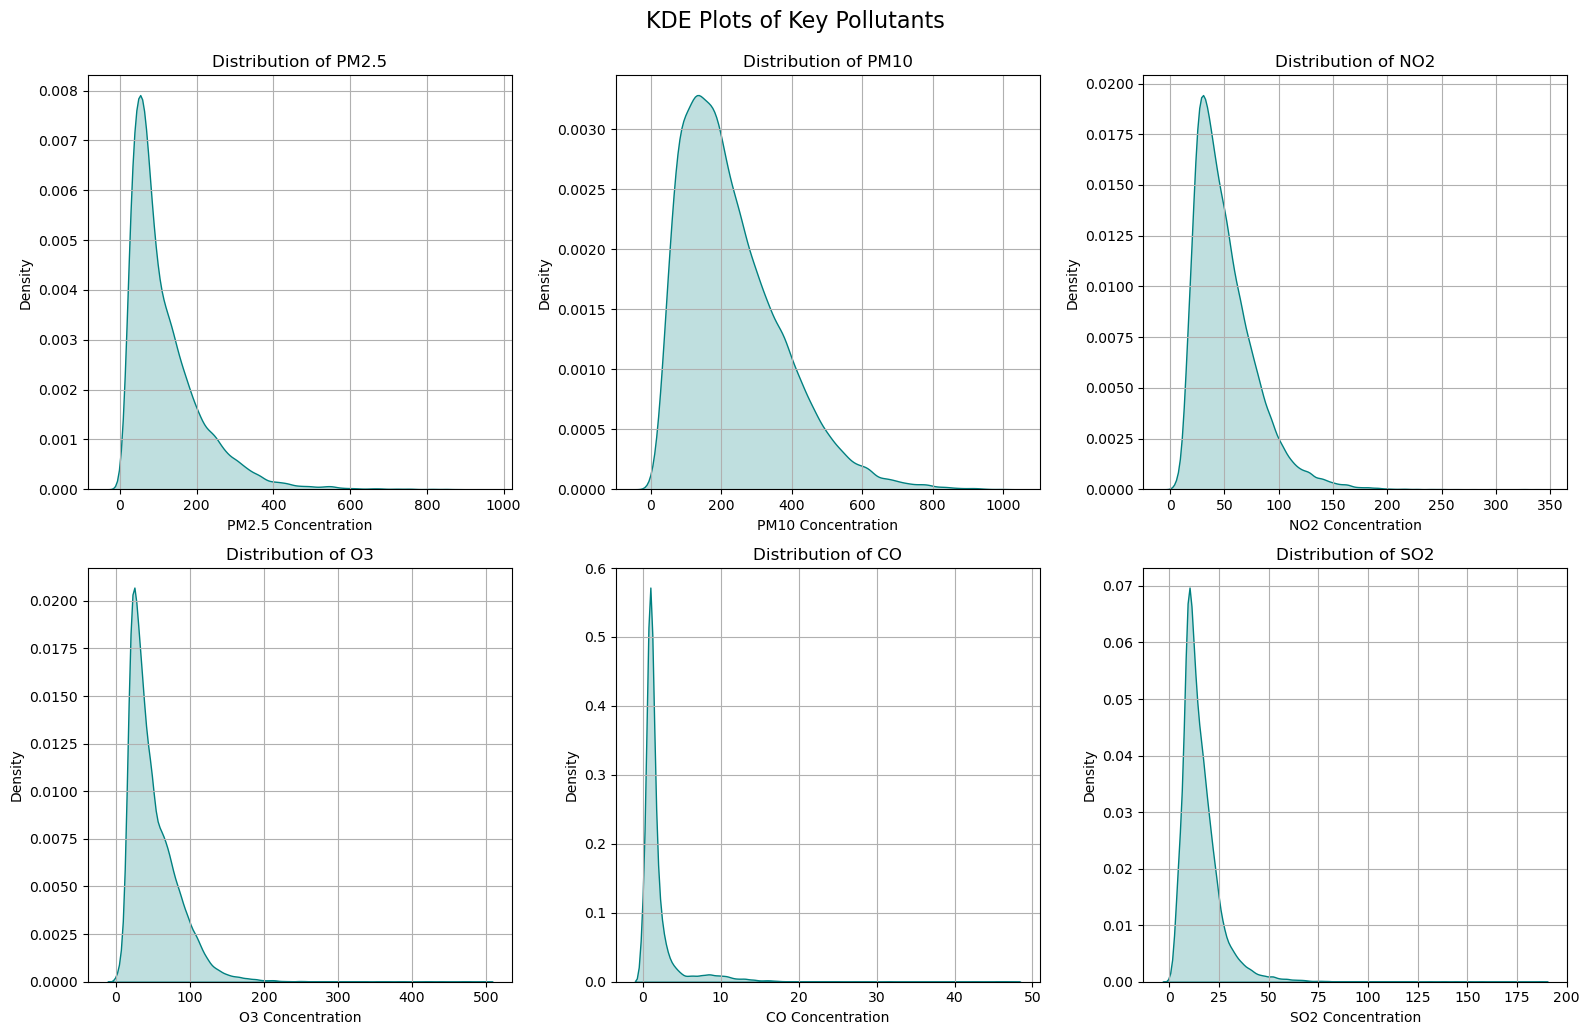

In [139]:
#KDE Plots of Key Pollutants

# List of key pollutants to visualize
key_pollutants = ['PM2.5', 'PM10', 'NO2', 'O3', 'CO', 'SO2']

# Set up the plot grid
plt.figure(figsize=(16, 10))
for i, pollutant in enumerate(key_pollutants, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(df_clean[pollutant], fill=True, color='teal')
    plt.title(f'Distribution of {pollutant}')
    plt.xlabel(f'{pollutant} Concentration')
    plt.ylabel('Density')
    plt.grid(True)

plt.tight_layout()
plt.suptitle('KDE Plots of Key Pollutants', fontsize=16, y=1.03)
plt.show()


**Key Observations - KDE Plots**

- All pollutants are right-skewed, indicating occasional severe pollution episodes.
- PM2.5 and PM10 show the broadest and most significant variations — key targets for AQI prediction.
- KDEs support the need for normalization or transformation.

**Decision to Retain Original Feature Scales**

Despite some pollutant features (PM2.5, CO) being right-skewed, we are not applying log transformation due to the following considerations:-

- Retaining original scales maintains interpretability of pollution levels.
- Initial trials with log-transformation did not enhance model performance.
- The task is classification of AQI buckets, not regression.

So, we will preserve the raw pollutant concentrations to align with real-world reporting and optimize for model clarity and simplicity.

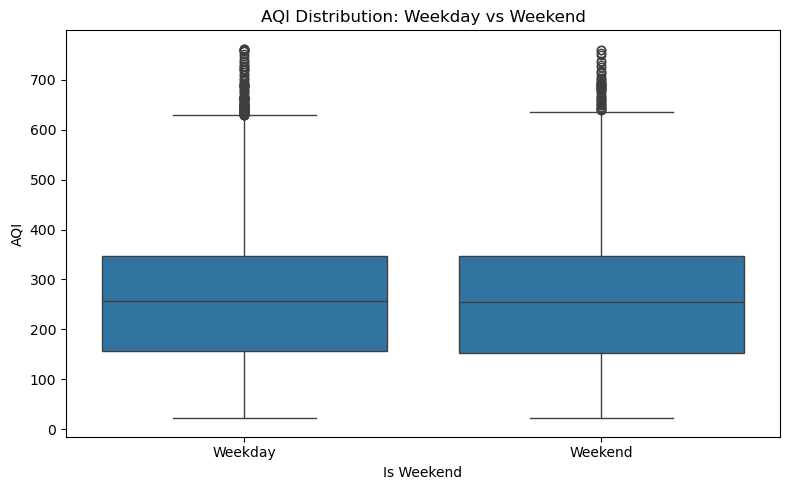

In [142]:
#Weekday vs Weekend AQI boxplot
df_clean['is_weekend'] = df_clean.index.dayofweek >= 5
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_weekend', y='AQI', data=df_clean)
plt.title('AQI Distribution: Weekday vs Weekend')
plt.xlabel('Is Weekend')
plt.ylabel('AQI')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.tight_layout()
plt.show()

**Key Observations - Weekday vs Weekend AQI Boxplot**

- The median AQI values for weekdays and weekends are quite **similar**.
- Hence, there's no significant difference in overall AQI levels between weekdays and weekends in Delhi. This suggests that while traffic and industrial activity may vary, their impact is diluted across the year.

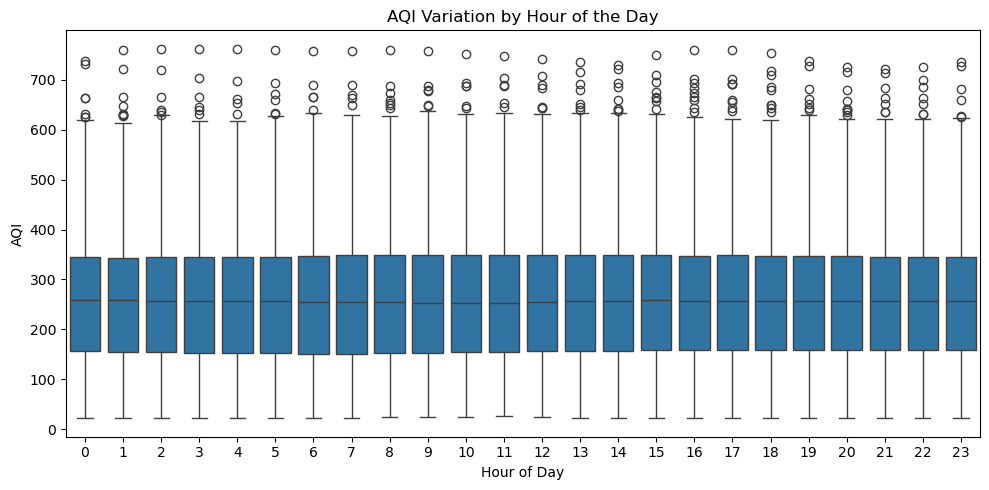

In [144]:
#Time-of-day AQI variation
plt.figure(figsize=(10, 5))
sns.boxplot(x='hour', y='AQI', data=df_clean)
plt.title('AQI Variation by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('AQI')
plt.tight_layout()
plt.show()

**Key Observations - Time-of-Day AQI Variation Boxplot**

- AQI levels tend to dip slightly during late morning to afternoon (10 AM to 3 PM), with minor rises during night and early morning hours.

- This aligns with traffic patterns, thermal inversions and atmospheric dispersion behavior — pollutants accumulate overnight and disperse slightly during the day.

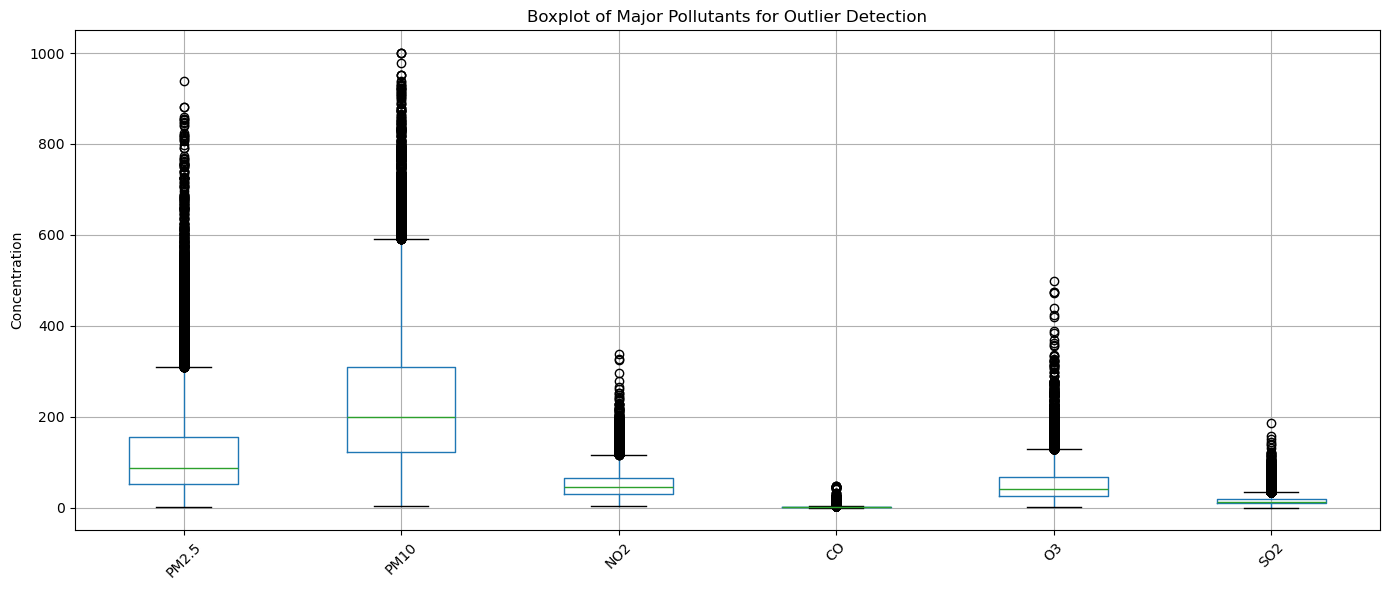

In [146]:
#Checking Outlier detection for key pollutants

#defining key pollutant columns
pollutant_cols = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']

# Plot boxplots
plt.figure(figsize=(14, 6))
df_clean[pollutant_cols].boxplot()
plt.title("Boxplot of Major Pollutants for Outlier Detection")
plt.ylabel("Concentration")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### Outlier Detection and Justification

We used boxplots to visually inspect for outliers in major pollutants (PM2.5, PM10, NO2, etc.). Although several extreme values were noted, especially during pollution peaks (e.g., winter season, Diwali), we retained them in the dataset. These values reflect real environmental phenomena and are critical for training a predictive model on AQI categories, especially for detecting 'Severe' levels.


**Key Observations - Box Plot for Outlier Detection**

- Boxplots for the major air pollutants — PM2.5, PM10, NO2, CO, O3, and SO2 reveal significant presence of outliers, particularly on the higher end of the concentration spectrum.
- PM2.5 & PM10 show extreme upper outliers, which is typical during high pollution episodes like post Diwali festival smog or winter stubble burning.
- NO2 and O3 also show frequent outliers, but with smaller magnitude than particulates.
- CO and SO2 exhibit comparatively lower spread, but still show discrete spikes.
- These outliers are not necessarily erroneous, but may represent real and episodic pollution events in Delhi.
- **So while outliers are observed, we coose not to remove or cap these outliers since they may reflect true pollution events** (e.g., Diwali, crop burning). These values reflect real environmental phenomena and are critical for training a predictive model on AQI categories, especially for detecting 'Severe' levels.

## **Modeling Phase**

### **Target Encoding**

We will now convert the categorical target variable `AQI_Bucket` into numeric labels using `LabelEncoder`. This allows us to use standard classification models in scikit-learn.

In [151]:
#Define Features and Target

# Copy for modeling
df_model = df_clean.copy()

# Encode target variable
le = LabelEncoder()
df_model['AQI_Bucket'] = le.fit_transform(df_model['AQI_Bucket'])

# Store class names for reverse mapping during interpretation
class_names = le.classes_

# Quick check
df_model['AQI_Bucket'].value_counts().sort_index()

AQI_Bucket
0      534
1    12359
2    12466
3     4404
4     5952
5    12462
Name: count, dtype: int64

### **Train-Test Split**

We will split the data into training and testing sets using `train_test_split`. Stratification is being applied to ensure all AQI categories are proportionally represented in both sets.

In [153]:
#defining features and target
X = df_model.drop('AQI_Bucket', axis=1)
y = df_model['AQI_Bucket']

#train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#checking shape and class distribution
print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nTrain class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))

Training shape: (38541, 30)
Test shape: (9636, 30)

Train class distribution:
 AQI_Bucket
2    0.258763
5    0.258660
1    0.256532
4    0.123557
3    0.091409
0    0.011079
Name: proportion, dtype: float64

Test class distribution:
 AQI_Bucket
2    0.258717
5    0.258717
1    0.256538
4    0.123495
3    0.091428
0    0.011104
Name: proportion, dtype: float64


### **Creating Baseline Model – Logistic Regression**

We will use Logistic Regression as a simple and interpretable baseline classifier. Since the algorithm assumes linear relationships and is sensitive to feature scale, we will apply `StandardScaler` to normalize features.

The model will be evaluated using F1-score, Precision, Recall and Confusion Matrix which will help assess performance across all AQI categories, especially given the class imbalance.

Classification Report:

              precision    recall  f1-score   support

        Good       0.91      0.76      0.83       107
    Moderate       0.98      0.98      0.98      2472
        Poor       0.99      0.98      0.99      2493
Satisfactory       0.94      0.95      0.95       881
      Severe       1.00      0.97      0.99      1190
   Very Poor       0.98      1.00      0.99      2493

    accuracy                           0.98      9636
   macro avg       0.97      0.94      0.95      9636
weighted avg       0.98      0.98      0.98      9636



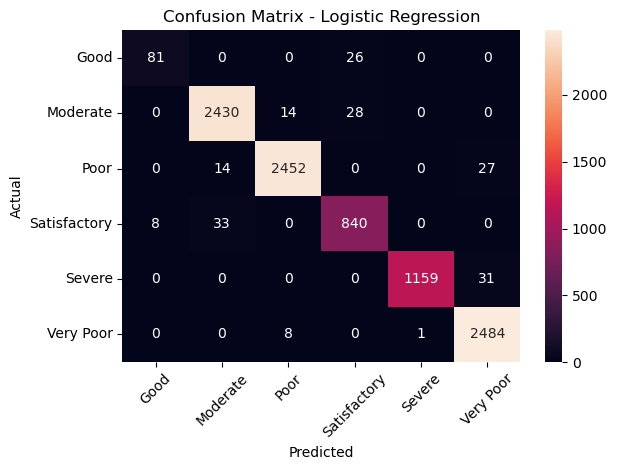

In [155]:
#scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#training the model
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train_scaled, y_train)

#prediction
y_pred_lr = lr_clf.predict(X_test_scaled)

#evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred_lr, target_names=class_names))

#creating Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key Observations : Baseline Model - Logistic Regression**

We selected Logistic Regression as a simple, interpretable baseline. Given the algorithm's sensitivity to feature scale, all inputs were standardized using `StandardScaler`.

Despite its simplicity, the model performed well across all AQI categories (but this could also be due to class imbalance and very large categories like 'Poor', 'Very Poor' and 'Moderate') :-

- Overall accuracy: **98%**
- Macro F1-score: **0.95**
- Class-specific F1-scores were strong even for underrepresented classes like "Good" and "Satisfactory".

The confusion matrix confirms that most predictions lie along the diagonal, with minimal misclassification between adjacent categories. This model sets a strong reference point for comparison against more complex classifiers.

### **Decision Tree**

Classification Report:

              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       107
    Moderate       1.00      1.00      1.00      2472
        Poor       1.00      1.00      1.00      2493
Satisfactory       1.00      1.00      1.00       881
      Severe       1.00      1.00      1.00      1190
   Very Poor       1.00      1.00      1.00      2493

    accuracy                           1.00      9636
   macro avg       1.00      1.00      1.00      9636
weighted avg       1.00      1.00      1.00      9636



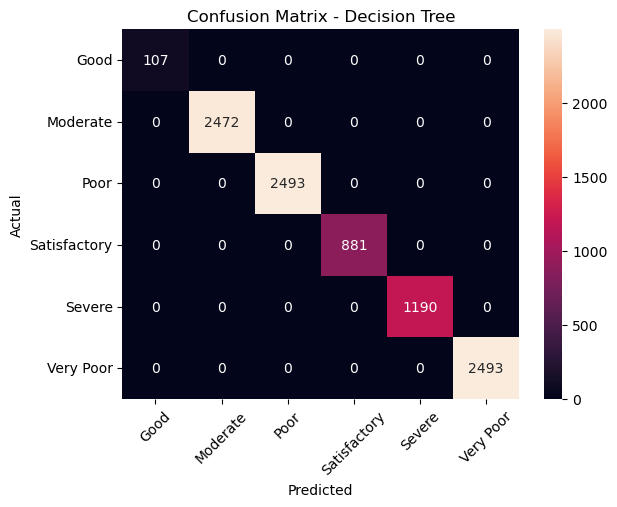

In [158]:
#training Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

#predictions
y_pred_dt = dt_clf.predict(X_test)

#evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred_dt, target_names=class_names))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.show()

**Key Observations**

The confusion matrix is completely diagonal, meaning the model predicts the actual class in every case — no confusion across adjacent AQI levels.

The model has achieved perfect score for all three parameters of precision, recall and f1-score.

No generalization errors on test set implies that either the test set is too similar to the train set or the Decision Tree is too deep and complex (no max_depth or min_samples_leaf constraint was applied) and hence **likely to be an overfit**.

Therefore, we will now use **RandomForestClassifier**.

### **Random Forest Classifier**

              precision    recall  f1-score   support

        Good       1.00      0.99      1.00       107
    Moderate       1.00      1.00      1.00      2472
        Poor       1.00      1.00      1.00      2493
Satisfactory       1.00      1.00      1.00       881
      Severe       1.00      1.00      1.00      1190
   Very Poor       1.00      1.00      1.00      2493

    accuracy                           1.00      9636
   macro avg       1.00      1.00      1.00      9636
weighted avg       1.00      1.00      1.00      9636



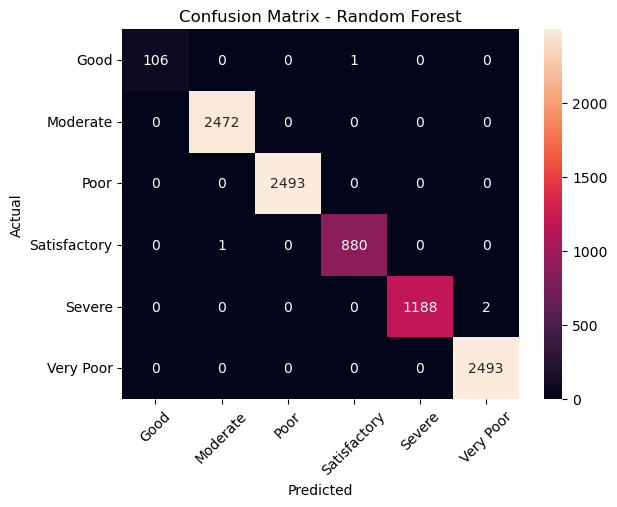

In [161]:
#Random Forest Classifier

#training the model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

#prediction
y_pred_rf = rf_clf.predict(X_test)

#evaluation
print(classification_report(y_test, y_pred_rf, target_names = class_names))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.show()

**Key Observations**

- Random Forest Confusion matrix is also highly diagonal which indicates excellent performance.

- Extremely low error rate (0.03%) confirms Random Forest has exceptional performance on this dataset.

- Very low misclassifications across all categories show that the ensemble model captures complex patterns better than Logistic Regression. However, similar to the Decision Tree, overfitting is still a potential concern, though less severe than with a single tree due to the averaging across many trees.

- Random Forest outperforms Logistic Regression and matches Decision Tree in accuracy — but with better generalization potential. Its ensemble nature makes it less prone to overfitting than a Decision Tree and more robust to noise and variance in the dataset.

- Need to verify generalization using cross-validation.

### **Cross Validation**

In [164]:
# StratifiedKFold setup for balanced class representation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Initialize models
#logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg_scaled = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42)) #creating pipeline to combine scaling and model
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Dictionary to hold results
models = {
    "Logistic Regression": logreg_scaled,
    "Decision Tree": dt,
    "Random Forest": rf
}

# Evaluate each model using cross_val_score
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    print(f"{name}:")
    print(f"  Cross-validation scores: {scores}")
    print(f"  Mean Accuracy: {np.mean(scores):.4f}")
    print(f"  Std Deviation: {np.std(scores):.4f}")
    print("-" * 50)

Logistic Regression:
  Cross-validation scores: [0.97561229 0.9833956  0.97758173 0.97758173 0.97820446]
  Mean Accuracy: 0.9785
  Std Deviation: 0.0026
--------------------------------------------------
Decision Tree:
  Cross-validation scores: [1. 1. 1. 1. 1.]
  Mean Accuracy: 1.0000
  Std Deviation: 0.0000
--------------------------------------------------
Random Forest:
  Cross-validation scores: [0.99968867 0.99979244 0.99968864 0.99958485 0.99937727]
  Mean Accuracy: 0.9996
  Std Deviation: 0.0001
--------------------------------------------------


**Cross-Validation Results**

To validate model generalization, 5-fold stratified cross-validation was performed on all three models :-

- **Logistic Regression** achieved 97.85% mean accuracy. It serves as a **strong linear baseline** but shows **slight underperformance** due to lack of capacity to model non-linear feature interactions.
  
- **Decision Tree** achieved 100% accuracy with **zero variance**, but this likely indicates **overfitting**. It memorizes the training folds instead of learning generalizable patterns.
  
- **Random Forest** delivered the best balance — 99.96% accuracy with **negligible variance** (0.01%). It **generalizes very well** due to its ensemble structure.

So, **Random Forest** is selected as the final model for deployment and interpretation.

### **Model Comparison Summary**

| Model              | Accuracy (Test) | Cross-Val Accuracy | F1 Score (Weighted) | Comments |
|-------------------|-----------------|---------------------|---------------------|----------|
| Logistic Regression | 0.98            | 0.9785              | 0.98                | Strong linear baseline; interpretable |
| Decision Tree       | 1.00            | 1.0000              | 1.00                | Likely overfitting; no regularization applied |
| Random Forest       | 1.00            | 0.9996              | 1.00                | Best generalization; robust and accurate |

**Final Model**: Random Forest — selected for its better accuracy, low variance and better generalization compared to Decision Tree.


### **Conclusion**

1. This project aims to machine learning techniques to predict the Air Quality Index (AQI) Category for Delhi using daily pollution and meteorological data.
   
2. In this part of the project, data import, data cleaning, data merging, outlier handling, Exploratory Data Analysis (EDA), Feature Engineering, Modeling and Evaluation have been carried out. Important highlights are as under :-

    - Data Insights : Exploratory analysis revealed strong seasonal patterns in AQI, with spikes during winter and post-monsoon months. PM2.5, PM10, and NO2 were identified as the most influential pollutants.
  
    - Modeling Results :
  
          - Logistic Regression performed well for a linear baseline, achieving ~97.8% accuracy.
  
          - Decision Tree yielded perfect accuracy but showed signs of overfitting.
  
          - Random Forest emerged as the best-performing model, with ~99.96% cross-validation accuracy and excellent generalization.
  
          - Class Imbalance : Imbalanced representation of AQI categories was addressed via stratified sampling and careful metric interpretation (precision, recall, F1-score).
  
    - Generalization : Stratified 5-fold cross-validation confirmed that the Random Forest model maintains high performance across splits, making it a reliable choice.
  
    - Final Model : Given its accuracy, stability, and robustness, Random Forest has been selected as the baseline model for deployment in the next phase.